# Import Libraries

In [49]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import copy
import math
from __future__ import division

import cPickle

import os
from scipy.io import loadmat

In [2]:
#plt.show() in jupyter notebook
%matplotlib inline

# Part 1

#### Analysis Data

In [51]:
def Counts(d):
    '''
    input: a list of lists of strings that represents one new title
    output: a dictionary that contains every word appeared and its count. To be precise, key is word and value is count.
    '''
    wordsCounts = {}
    for i in d:
        temp = []
        for j in i:
            if j in temp:
                continue
            else:
                temp.append(j)
                if j not in wordsCounts:
                    wordsCounts[j] = 1.0
                else:
                    wordsCounts[j] += 1.0

    return wordsCounts

the 1-th most prevealing word in fake news is trump :1282
the 2-th most prevealing word in fake news is to :366
the 3-th most prevealing word in fake news is the :363
the 4-th most prevealing word in fake news is donald :228
the 5-th most prevealing word in fake news is in :218
the 6-th most prevealing word in fake news is of :197
the 7-th most prevealing word in fake news is for :196
the 8-th most prevealing word in fake news is a :172
the 9-th most prevealing word in fake news is and :166
the 10-th most prevealing word in fake news is on :160


the 1-th most prevealing word in real news is trump :1739
the 2-th most prevealing word in real news is donald :828
the 3-th most prevealing word in real news is to :380
the 4-th most prevealing word in real news is us :230
the 5-th most prevealing word in real news is trumps :219
the 6-th most prevealing word in real news is in :213
the 7-th most prevealing word in real news is on :204
the 8-th most prevealing word in real news is of :181
the

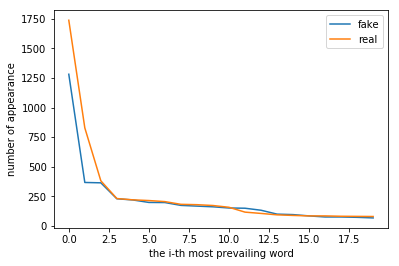

In [52]:
#import fakeData and realData from text files
fakeData = [line.rstrip('\n').split(' ') for line in open('clean_fake.txt')]
realData = [line.rstrip('\n').split(' ') for line in open('clean_real.txt')]

#count words in realData and fakeData
fakeWordsCounts = Counts(fakeData)
realWordsCounts = Counts(realData)
            
#sort words according to how often they appear
fakeWordsInOrder = sorted(fakeWordsCounts, key = fakeWordsCounts.__getitem__, reverse=True)
realWordsInOrder = sorted(realWordsCounts, key = realWordsCounts.__getitem__, reverse=True)

#plot
fig = plt.figure(11)
plt.plot(range(20), [fakeWordsCounts[fakeWordsInOrder[i]] for i in range(20)], label = "fake")
plt.plot(range(20), [realWordsCounts[realWordsInOrder[i]] for i in range(20)], label = "real")
plt.ylabel("number of appearance")
plt.xlabel("the i-th most prevailing word")
plt.legend(loc = "best")

#print the most prevailing words:
for i in range(10):
    print "the %i-th most prevealing word in fake news is %s :%i"%(i+1,fakeWordsInOrder[i],fakeWordsCounts[fakeWordsInOrder[i]])
print('\n')
for i in range(10):
    print "the %i-th most prevealing word in real news is %s :%i"%(i+1,realWordsInOrder[i],realWordsCounts[realWordsInOrder[i]])

#### Spliting data


In [100]:
random.seed(0)
fakeDataCopy = copy.deepcopy(fakeData)
realDataCopy = copy.deepcopy(realData)
random.shuffle(fakeDataCopy)
random.shuffle(realDataCopy)

fakeTrain = fakeDataCopy[:int(len(fakeDataCopy)*0.7)]
fakeVali = fakeDataCopy[int(len(fakeDataCopy)*0.7):int(len(fakeDataCopy)*0.85)]
fakeTest = fakeDataCopy[int(len(fakeDataCopy)*0.85):]

realTrain = realDataCopy[:int(len(realDataCopy)*0.7)]
realVali = realDataCopy[int(len(realDataCopy)*0.7):int(len(realDataCopy)*0.85)]
realTest = realDataCopy[int(len(realDataCopy)*0.85):]

# Part 2

#### Contruct Data and define helper functions

In [104]:
#construct wordList that contains all the words appeared in training sets
wordList = []
for i in fakeTrain:
    wordList.extend(i)
for i in realTrain:
    wordList.extend(i)
wordList = sorted(set(wordList), key=wordList.index)

#Getting parameter:
fakeWordsCountsTrain = Counts(fakeTrain)
realWordsCountsTrain = Counts(realTrain)

In [163]:
def Performance(wordsProb, p_fake, fakeData, realData):
    '''
    input:
        wordsProb: a dictionary whose key is the word xi and value is a list: the first element in sublist is P(xi=1|fake), the second element is sublist is P(xi=1|real).
        fakeData: a list of lists of words, each sublist is a single new. 
        realData: a list of lists of words, each sublist is a single new. 
        p_fake: P(fake)
    output:
        percentage performance on fakeData and real Data
    '''
    correct = 0.0
    for i in fakeData:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb += math.log(p_fake)
        realProb += math.log(1-p_fake)
        
        if fakeProb >= realProb:
            correct += 1

    for i in realData:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb += math.log(p_fake)
        realProb += math.log(1-p_fake)

        if fakeProb <= realProb:
            correct += 1        

    perf = float(correct)/float(len(fakeData)+len(realData))
    return perf

In [170]:
def NaiveBayes(m, pHat, ifprint = True, ifreturnProb = False):
    '''
    Given m and pHat, return the performance on Training set, Validation set and Test set.
    '''
    if ifprint:
        print "running NaiveBayes with m = %05.5f, pHat = %05.5f"%(m, pHat)

    wordsProb={} #a dictionary whose key is the word xi and value is a list: the first element in sublist is P(xi=1|fake), the second element is sublist is P(xi=1|real).
    for i in wordList:
        if i in fakeWordsCountsTrain:
            p_x_fake = float(fakeWordsCountsTrain[i] + m*pHat)/float(len(fakeTrain) + m)
        else:
            p_x_fake = float(m*pHat)/float(len(fakeTrain) + m)
        if i in realWordsCountsTrain:
            p_x_real = float(realWordsCountsTrain[i] + m*pHat)/float(len(realTrain) + m)
        else:
            p_x_real = float(m*pHat)/float(len(realTrain) + m)
        wordsProb[i] = [p_x_fake,p_x_real]

    p_fake = float(len(fakeTrain))/float(len(realTrain) + len(fakeTrain)) #P(fake)
    
    perfTrain = Performance(wordsProb, p_fake, fakeTrain, realTrain)
    perfVali = Performance(wordsProb, p_fake, fakeVali, realVali)
    perfTest = Performance(wordsProb, p_fake, fakeTest, realTest)
    
    if ifreturnProb:
        return perfTrain, perfVali, perfTest, wordsProb, p_fake
    else:
        return perfTrain, perfVali, perfTest

#### Tune m and pHat using validation sets

When m = 3.1623, pHat = 0.10000, the performance on validation set is highest:0.88571


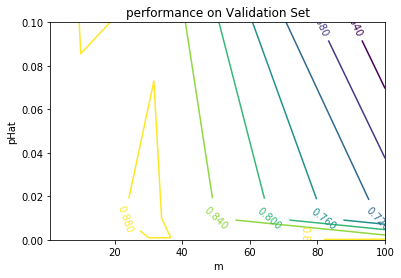

In [155]:
perfValiArray = []
m_ = [10**exp for exp in np.arange(0,2.5,0.5, dtype=float)]
pHat_ = [10**exp for exp in np.arange(-5,0, dtype=float)]
bestPerf = -10000000
for m in m_:
    temp = []
    for pHat in pHat_:
        temp0, temp1, temp2 = NaiveBayes(int(m),pHat,ifprint = False)
        temp.append(temp1)
        if temp1 > bestPerf:
            bestM = m
            bestPHat = pHat
            bestPerf = temp1
    perfValiArray.append(temp)
    
M_,PHat_ = np.meshgrid(m_,pHat_)
ax1 = subplot(111) 
CS = ax1.contour(M_,PHat_,perfValiArray)
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel("pHat")
plt.xlabel("m")
plt.title("performance on Validation Set")

print "When m = %04.4f, pHat = %05.5f, the performance on validation set is highest:%05.5f"%(bestM, bestPHat,bestPerf)

#### Performance on chosen m and pHat

In [167]:
perfTrain, perfVali, perfTest = NaiveBayes(3.1623, 0.10000, ifprint = False)
print "Performance on Training Set is %05.5f"%perfTrain
print "Performance on Validation Set is %05.5f"%perfVali
print "Performance on Test Set is %05.5f"%perfTest

Performance on Training Set is 0.96193
Performance on Validation Set is 0.88776
Performance on Test Set is 0.84725


# Part 3

### Part 3a

In [188]:
perfTrain, perfVali, perfTest, wordsProb, p_fake = NaiveBayes(3.1623, 0.10000, ifprint = False, ifreturnProb = True)
fakeWordsInProb = {}
realWordsInProb = {}
for i in wordsProb:
    fakeWordsInProb[i] = wordsProb[i][0]
    realWordsInProb[i] = wordsProb[i][1]
fakeWordsInProb = sorted(fakeWordsInProb, key = fakeWordsInProb.__getitem__, reverse=True)
realWordsInProb = sorted(realWordsInProb, key = realWordsInProb.__getitem__, reverse=True)
for i in range(0,10):
    print "the %i-th strongly predicts real news with its presence is %s"%(i+1, realWordsInProb[i])
print "\n"
for i in np.arange(-1,-11,-1):
    print "the %i-th strongly predicts real news with its absence is %s"%(-i, realWordsInProb[i])
print "\n"
for i in range(0,10):
    print "the %i-th strongly predicts fake news with its presence is %s"%(i+1, fakeWordsInProb[i])
print "\n"
for i in np.arange(-1,-11,-1):
    print "the %i-th strongly predicts fake news with its absence is %s"%(-i, fakeWordsInProb[i])

the 1-th strongly predicts real news with its presence is trump
the 2-th strongly predicts real news with its presence is donald
the 3-th strongly predicts real news with its presence is to
the 4-th strongly predicts real news with its presence is us
the 5-th strongly predicts real news with its presence is in
the 6-th strongly predicts real news with its presence is trumps
the 7-th strongly predicts real news with its presence is on
the 8-th strongly predicts real news with its presence is of
the 9-th strongly predicts real news with its presence is says
the 10-th strongly predicts real news with its presence is the


the 1-th strongly predicts real news with its absence is 8th
the 2-th strongly predicts real news with its absence is yell
the 3-th strongly predicts real news with its absence is uneducated
the 4-th strongly predicts real news with its absence is rounding
the 5-th strongly predicts real news with its absence is casual
the 6-th strongly predicts real news with its absenc

### Part 3b

In [192]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

i = 0
index = 0
while i < 10:
    if realWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts real news with its presence is %s"%(i+1, realWordsInProb[index])
        i += 1
    index += 1
print "\n"

i = 0
index = -1
while i < 10:
    if realWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts real news with its absence is %s"%(i+1, realWordsInProb[index])
        i +=1
    index -= 1
print "\n"
        
i = 0
index = 0
while i < 10:
    if fakeWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts fake news with its presence is %s"%(i+1, fakeWordsInProb[index])
        i += 1
    index += 1
print "\n"

i = 0
index = -1
while i < 10:
    if fakeWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts fake news with its absence is %s"%(i+1, fakeWordsInProb[index])
        i +=1
    index -= 1
print "\n"

the 1-th strongly predicts real news with its presence is trump
the 2-th strongly predicts real news with its presence is donald
the 3-th strongly predicts real news with its presence is trumps
the 4-th strongly predicts real news with its presence is says
the 5-th strongly predicts real news with its presence is clinton
the 6-th strongly predicts real news with its presence is election
the 7-th strongly predicts real news with its presence is ban
the 8-th strongly predicts real news with its presence is north
the 9-th strongly predicts real news with its presence is russia
the 10-th strongly predicts real news with its presence is korea


the 1-th strongly predicts real news with its absence is 8th
the 2-th strongly predicts real news with its absence is yell
the 3-th strongly predicts real news with its absence is uneducated
the 4-th strongly predicts real news with its absence is rounding
the 5-th strongly predicts real news with its absence is casual
the 6-th strongly predicts real

### Part 3c

Bond ganbaru!!!!

# Part 4

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def f(x, y, theta, lamb):
	x = vstack((ones((1, x.shape[1])), x))
    output = sigmoid(np.dot(theta.T,x))
	return (-sum(y*log(output)+(1-y)*log(1-output))+ lamb*np.dot(theta.T,theta))/(2*y.shape[0])


def df(x, y, theta, lamb):
	x = vstack((ones((1, x.shape[1])), x))
    output = sigmoid(np.dot(theta.T,x))
	return (+lamb*theta)/(2*y.shape[0])


def performance(X, Y, theta):
	X = vstack((np.ones((1, X.shape[1])), X))
	h = dot(theta.T, X)
	cor = 0
	for i in range(len(Y)):
		if Y[i] == 1 and h[i] > 0:
			cor += 1
		elif Y[i] == -1 and h[i] < 0:
			cor += 1
	return float(cor) / len(Y)


def grad_descent(f, df, x, y, init_t, alpha, EPS=1e-5, max_iter=80000):
	prev_t = init_t - 10 * EPS
	t = init_t.copy()
	iter = 0
	cost_func_ = []
	while norm(t - prev_t) > EPS and iter < max_iter:
		cost_func_.append(f(x,y,t))
		prev_t = t.copy()
		t -= alpha * df(x, y, t)
		if iter % 500 == 0:
			print "Iter", iter
			print "Cost", f(x, y, t)
			print "Gradient: ", df(x, y, t), "\n"
		iter += 1
		
	return t, cost_func_

def part3(alpha= 0.000010, st_devi = 0, max_iteration = 80000):
	X_train = np.hstack((act_data['Alec Baldwin'][0], act_data['Steve Carell'][0]))
	Y_train = np.append(np.ones(act_data['Alec Baldwin'][0].shape[1]),
						np.full(act_data['Steve Carell'][0].shape[1], -1))
	X_vali = np.hstack((act_data['Alec Baldwin'][1], act_data['Steve Carell'][1]))
	Y_vali = np.append(np.ones(10), np.full(10, -1))
	X_test = np.hstack((act_data['Alec Baldwin'][2], act_data['Steve Carell'][2]))
	Y_test = np.append(np.ones(10), np.full(10, -1))

	np.random.seed(0)
	theta0 = np.random.normal(scale=st_devi, size=1025)
	theta, cost_func_ = grad_descent(f, df, X_train, Y_train, theta0, alpha, max_iter = max_iteration)

	print("This is the result for part3")
	print("Cost function on training set:", f(X_train, Y_train, theta), "Normalized:", f(X_train, Y_train, theta)/(Y_train.shape[0]))
	print("Cost function on validation set:", f(X_vali, Y_vali, theta), "Normalized:", f(X_vali, Y_vali, theta)/(Y_vali.shape[0]))
	print("Performance on training set", performance(X_train, Y_train, theta))
	print("Performance on validation set", performance(X_vali, Y_vali, theta))

	return theta